# Astro9 Final Project - Predicting Hockey Player Trajectories



### Introduction and Motivation
As a (true) Canadian I've always followed my hometown team, the Vancouver Canucks, through the highs and lows. Naturally, I received a lot of exposure to sports analytics through reading articles, watching ESPN and other sports channels, and from just following hockey in general. Each season, every team will make trades and free ageng signings and try to improve their team just like in any other professional sports league. The Canucks, in particular, have made some questionable offseason moves in the past few years, and so my motivation for this project was to answer the following question: How well can we predict player trajectories based on statistics and numbers alone?

### Foreword
I know that in my proposal and homework 5 project updates I wrote completely different topics. I initially wanted to start with predicting stock trajectories, but after doing some research and playing around with the data I decided to settle on a more creative and simple endeavor. My initial thought when I got to hockey, then, was to analyze prospect trajectories especially since that's where a lot of the algorithms we learned in class could potentially be applied. However, that proved difficult as well, for two main reasons. The first is that hockey is somewhat lagging in terms of analytics in terms of other sports, and the leagues that prospects play in often don't offer a full range of game-by-game statistics. The second is that there also weren't many official sources, and writing a scraper, although possible, wasn't something I thought to be a good use of time.

### Explanation of Data Used
My main source of data was corsica.hockey, and I focused on in-game player data since my goal was to predict player trajectories - that is, how a player is projected to trend in the future based on their performance in current and past seasons. I restricted my analysis to forwards only (the main positions in hockey are forward, defense, and goalie, and there's large variances across these categories), and only took statistics for 5v5 play (as opposed to having one team down a man, which happens when players take penalties and are sent to the 'penalty box' for a period of time). This was because strategies are often much different and coahces usually favor a select group of players for 5v4 situations, which would skew stats either in favor of or against those players. 

I already did some pre-processing with Excel before reading it through. 'g-adj', 'a-adj', 'p-adj' are statistics I added that weren't originally in the data, and these are just goals, assists, and points, respectively, scaled to 82 games (since players often miss games due to injury, more so than other sports because hockey is a very rough and physical game).

In addition, I took players who played above 600 minutes on the season. One reason is that teams, especially when injuries hit, tend to call up minor league players who may only play one or two games. They may happen to get lucky and do quite well, especially since the opposing team would tend to overestimate call-up players, but only play 3 or 4 games. Under the scaling system they would appear to be extremely good players when their stats are extrapolated across 82 games when in reality there's no way they could have kept up their production. The second reason is to remove outliers - whether or not we're using the adjusted stats (as opposed to regular goals (G), assists (A), and points(P)), they would have negatively impacted the accuracy of the data since if a player only got half the points he could have due to injury that would not have been a great indicator of trend or performance trajectory.

600 minutes, again, is a little arbitrary but the average forward plays about 15 - 20 minutes a game, so this translates to players who have played roughly half the season. Finally, I only took statistics from the regular season and not the playoffs since the playoffs include only half the teams and just for the sake of keeping it simple (while not necessarily disrupting the integrity of the data). 

In [778]:
#importing important packages and using ggplot for pretty graphs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
plt.style.use('ggplot')

In [781]:
#used to find the right encoding for the csv file
import chardet
# with open('full.csv', 'rb') as f:
#     result = chardet.detect(f.read('full.csv'))
# result['encoding']
    
all_data = pd.read_csv('full.csv', encoding='Windows-1252')
all_data.columns

Index(['Player', 'Year', 'Position', 'GP', 'TOI', 'G', 'A', 'P', 'g-adj',
       'a-adj', 'p-adj', 'P1', 'trend_next', 'trend_cur', 'P/60', 'P1/60',
       'GS', 'GS/60', 'CF', 'CA', 'C+/-', 'CF%', 'Rel CF%', 'GF', 'GA', 'G+/-',
       'GF%', 'Rel GF%', 'xGF', 'xGA', 'xG+/-', 'xGF%', 'Rel xGF%', 'iPENT',
       'iPEND', 'iP+/-', 'iCF', 'iCF/60', 'ixGF', 'ixGF/60', 'iSh%', 'PDO',
       'ZSR', 'TOI%', 'TOI% QoT', 'CF% QoT', 'TOI% QoC', 'CF% QoC'],
      dtype='object')

In [782]:
master = all_data[['Player', 'Year', 'Position', 'GP', 'TOI', 'G', 'A', 'P', 'P/60', 'g-adj', 'a-adj', 'p-adj', 'CF%', 'G+/-', 'xGF', 'trend_next', 'trend_cur']]
master.columns = ['player', 'year', 'pos', 'gp', 'toi', 'g', 'a', 'pts', 'p/60', 'g-adj', 'a-adj', 'p-adj', 'cf%', '+/-','xGF', 'trend-next','trend-cur']
master

,player,year,pos,gp,toi,g,a,pts,p/60,g-adj,a-adj,p-adj,cf%,+/-,xGF,trend-next,trend-cur
0,ADAM.BURISH,2010,R,63,744,7,6,13,1.05,9.111111,7.809524,16.920635,44.88,0,21.58,1,0
1,ADAM.BURISH,2011,R,65,686,5,10,15,1.31,6.307692,12.615385,18.923077,49.51,0,20.10,0,1
2,ADAM.BURISH,2012,R,46,418,0,2,2,0.29,0.000000,3.565217,3.565217,44.08,-6,12.36,0,0
3,ADAM.CRACKNELL,2016,R,69,676,9,6,15,1.33,10.695652,7.130435,17.826087,50.99,6,24.12,0,0
4,ADAM.ERNE,2018,L,65,631,5,12,17,1.62,6.307692,15.138462,21.446154,48.15,8,20.88,0,0
5,ADAM.HALL,2008,R,74,622,4,4,8,0.77,4.432432,4.432432,8.864865,47.80,-7,20.44,1,0
6,ADAM.HALL,2010,R,82,938,7,7,14,0.90,7.000000,7.000000,14.000000,49.68,-12,34.93,0,1
7,ADAM.HALL,2012,R,37,308,0,3,3,0.58,0.000000,6.648649,6.648649,39.79,-2,7.46,0,0
8,ADAM.HENRIQUE,2011,C,74,"1,050",10,21,31,1.77,11.081081,23.270270,34.351351,51.45,3,38.26,0,0
9,ADAM.HENRIQUE,2012,C,42,543,5,3,8,0.88,9.761905,5.857143,15.619048,57.00,-2,19.05,1,0


In [783]:
#converting toi values from strings to integers
import re
toint = lambda str: int(re.sub(',', '', str))
master['toi'] = master['toi'].apply(toint)

C:\Users\jerry\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [784]:
master.describe()

,year,gp,toi,g,a,pts,p/60,g-adj,a-adj,p-adj,cf%,+/-,xGF,trend-next,trend-cur
count,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000
mean,2013.101262,70.775674,887.970740,10.274527,14.123351,24.397877,1.605858,11.814786,16.244248,28.059034,50.275493,1.400746,34.022120,0.355135,0.355135
std,3.154976,12.319219,200.907774,5.322276,6.963586,10.793047,0.502606,5.585899,7.257123,10.905744,3.863147,10.584024,10.458074,0.478623,0.478623
min,2008.000000,23.000000,300.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34.170000,-33.000000,6.500000,0.000000,0.000000
25%,2010.000000,65.000000,744.000000,6.000000,9.000000,16.000000,1.260000,7.756757,11.014925,20.500000,47.740000,-6.000000,26.310000,0.000000,0.000000
50%,2013.000000,75.000000,911.000000,10.000000,13.000000,23.000000,1.590000,11.135802,15.375000,27.333333,50.370000,1.000000,33.895000,0.000000,0.000000
75%,2016.000000,80.000000,1046.000000,13.000000,18.000000,31.000000,1.940000,15.185185,20.500000,34.965646,52.867500,8.000000,41.310000,1.000000,1.000000
max,2018.000000,91.000000,1455.000000,41.000000,52.000000,71.000000,4.190000,41.000000,59.222222,86.555556,63.340000,45.000000,76.290000,1.000000,1.000000


In [662]:
_2015 = master[master.year == 2018]
_2015.describe()

,year,gp,toi,g,a,pts,p/60,g-adj,a-adj,p-adj,cf%,+/-,xGF,trend-next,trend-cur
count,335.0,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.0,335.000000
mean,2018.0,73.358209,931.597015,11.465672,15.328358,26.794030,1.672985,12.667477,16.982608,29.650084,50.262866,1.462687,37.984328,0.0,0.495522
std,0.0,8.107255,175.992248,5.766244,7.704086,11.893589,0.517965,5.967823,7.880098,11.913815,3.452644,10.752146,10.670763,0.0,0.500728
min,2018.0,48.000000,608.000000,0.000000,1.000000,5.000000,0.430000,0.000000,1.389831,6.949153,41.290000,-24.000000,18.910000,0.0,0.000000
25%,2018.0,68.500000,794.000000,7.000000,10.000000,17.000000,1.290000,8.328912,11.388889,20.912698,47.890000,-6.000000,29.515000,0.0,0.000000
50%,2018.0,76.000000,937.000000,11.000000,14.000000,25.000000,1.640000,11.714286,15.513514,27.333333,50.150000,0.000000,37.070000,0.0,0.000000
75%,2018.0,80.000000,1068.000000,15.000000,19.000000,34.000000,2.000000,16.400000,21.608918,38.058390,52.830000,8.000000,45.860000,0.0,1.000000
max,2018.0,82.000000,1380.000000,33.000000,44.000000,68.000000,3.310000,34.526316,44.000000,68.000000,59.460000,38.000000,65.510000,0.0,1.000000


Looking at the overall, 2015, and 2013 summairies (and some other years as well, but not shown here), it seems like the distribution of stats across each year is pretty consistent.

In [663]:
master[master.year == 2013].describe()

,year,gp,toi,g,a,pts,p/60,g-adj,a-adj,p-adj,cf%,+/-,xGF,trend-next,trend-cur
count,309.0,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000
mean,2013.0,73.346278,932.184466,10.533981,14.631068,25.165049,1.582686,11.729095,16.311723,28.040817,50.441586,1.543689,34.976084,0.378641,0.388350
std,0.0,8.253678,162.378391,5.195182,6.467185,10.228015,0.486717,5.577022,6.850852,10.706863,4.219646,11.952919,9.207916,0.485835,0.488165
min,2013.0,45.000000,601.000000,0.000000,2.000000,6.000000,0.480000,0.000000,2.129870,6.389610,38.840000,-28.000000,14.150000,0.000000,0.000000
25%,2013.0,69.000000,803.000000,7.000000,10.000000,18.000000,1.260000,7.653333,11.310345,20.759494,47.860000,-6.000000,28.120000,0.000000,0.000000
50%,2013.0,75.000000,945.000000,10.000000,14.000000,24.000000,1.550000,11.135802,15.726027,27.688312,50.820000,1.000000,34.400000,0.000000,0.000000
75%,2013.0,80.000000,1058.000000,14.000000,19.000000,32.000000,1.920000,15.000000,20.746988,34.526316,53.020000,10.000000,41.300000,1.000000,1.000000
max,2013.0,83.000000,1342.000000,31.000000,39.000000,58.000000,3.080000,31.382716,39.000000,59.636364,61.170000,34.000000,56.820000,1.000000,1.000000


Let's check out how some of these players have fared over the years. We'll take players who've played a minimum of 5 seasons across the span of our data, which is a little arbitrary but I think suffices to filter out outliers so that we get a good visualization of player trajectories rather than single or two-season stints which clutter the graph and are less informative. 

In [664]:
#grouping entries by player since there are multiple entries per player
grouped = master.groupby('player')#.plot(x='year', y='ppg', ax=ax, legend=False)
grouped

I just took the first few players from alphabetical order since alphabetical sorting is a good enough randomization. One thing to note is that due to the NHL players' union and NHL management having bargaining issues in the 2012-2013 season, the season was cut short to 48 games instead of the regular 82.

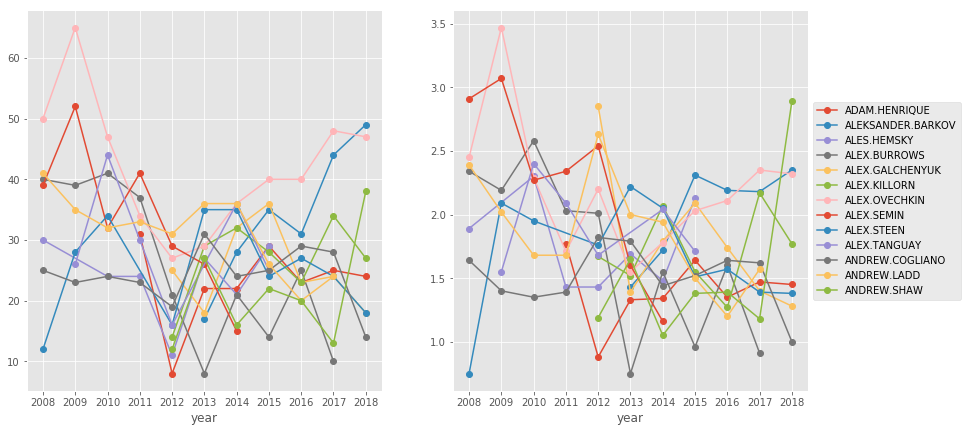

In [665]:
fig, ax = plt.subplots(1, 2, figsize=(14,7))
ticks = range(2008, 2019)
index = 0
names = []
for name, group in grouped:
    if index < 50 and len(group) > 5:
        names.append(name)
        group.plot(x='year', y='pts', ax=ax[0], style='-o', xticks=ticks, legend=False)
        group.plot(x='year', y='p/60', ax=ax[1], style='-o', xticks=ticks)
    index+=1
ax[1].legend(names, loc='center left', bbox_to_anchor=(1.0, 0.5))

One of the simplist models, although crude and not likely to be accurate, is just to do a linear regression and estimate how many points a player would get, based on points he got his previous seasons in the league. As the dataset does not account for player growth or any time or circumstancial related evidence, the data is naturally going to be wrong especially for players who for example are going into their second year, where they may improve on their point totals after a year of experience, or older players in their 30's who are well into decline. I decided to do this anyway just to get an idea of how the data would turn out and to also set a baseline for minimum performance. I also plotted three regressions for visualization purposes, and the last point is always going to be the test point (i.e. I did a regression fit on all datapoints before the last recorded year, and used the last as the testing data). 

In [666]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
clf = linear_model.LinearRegression()

In [667]:
reg_stats = master[['player','year', 'pos', 'gp', 'toi', 'g', 'a', 'pts', 'cf%',  '+/-']]
by_player = reg_stats.groupby('player')

         player  year  pos  gp   toi   g   a  pts    cf%  +/-
100  ALEX.SEMIN  2008    L  62   804  22  17   39  57.43   20
101  ALEX.SEMIN  2009  L/R  73  1015  29  23   52  54.11   33
102  ALEX.SEMIN  2010    R  64   847  18  14   32  54.12   20
103  ALEX.SEMIN  2011    R  77  1052  18  23   41  51.86   13
104  ALEX.SEMIN  2012    R  44   686   7  22   29  50.55   18
105  ALEX.SEMIN  2013    R  65   973  12  14   26  55.19    7
106  ALEX.SEMIN  2014    R  57   775   6   9   15  55.80   -4
[[24.]]
[]
         player  year  pos  gp   toi   g   a  pts    cf%  +/-
107  ALEX.STEEN  2008    C  80   961   3   9   12  48.91  -10
108  ALEX.STEEN  2009    C  68   802  14  14   28  49.96    9
109  ALEX.STEEN  2010    C  72  1046  16  18   34  56.67   -3
110  ALEX.STEEN  2012    C  40   545   4  12   16  54.71    7
111  ALEX.STEEN  2013  C/L  68   948  24  11   35  57.22   11
112  ALEX.STEEN  2014    L  74  1025  14  21   35  52.61   11
113  ALEX.STEEN  2015    L  67   955  12  12   24  49.86   

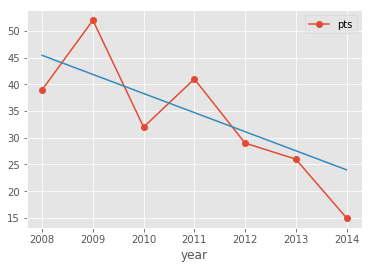

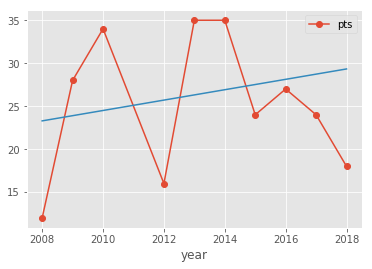

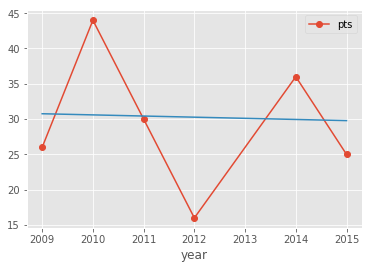

In [668]:
# x_train = master[master.year < 2017].iloc[:,0:(len(master.columns)-1)]
# y_train = master[master.year < 2017].iloc[:,(len(master.columns)-2):(len(master.columns)-1)]
# x_test = master[master.year == 2018].iloc[:,0:(len(master.columns)-1)]
# y_test = master[master.year == 2018].iloc[:,(len(master.columns)-1):(len(master.columns))]
# x_train['trend'] = y_train
# fig, ax = plt.subplots()
predicted_pts_2018 = []
ytests = np.array([])
ypredictions = np.array([])
i = 0
for name, group in by_player:
    i+=1
    if i < 30 and i > 25 and len(group) > 4:
        group.plot(x='year', y='pts', style="-o")
        print(group)
        if len(group) > 4:
            #xtrain and ytrain using stats up to 2017
            xtrain = np.array([[year] for year in group[0:len(group) - 1]['year']])
            ytrain = np.array([[pts] for pts in group[0:len(group) - 1]['pts']])
            
            #testing with 2018 stats
            xtest = np.array([[year] for year in group[len(group) - 1 : len(group)]['year']])
            ytest = np.array([[pts] for pts in group[len(group) - 1 : len(group)]['pts']])
#             ytests = np.concatenate((ytests.reshape(-1,1), np.array(ytest)))
            ytests = np.append(ytests, np.array(ytest))
       
            clf.fit(xtrain, ytrain) 
            ypredicted = clf.predict(xtest)
            print(ypredicted)
            print(ypredictions)
#             ypredictions = np.concatenate((ypredictions.reshape(-1,1), np.array(ypredicted)), axis=0)
            ypredictions = np.append(ypredictions, np.array(ypredicted))
    
            best_fit_line = clf.predict(np.array(np.concatenate((xtrain,xtest))))
            plt.plot(np.array(np.concatenate((xtrain,xtest))), best_fit_line)

print(ytests.shape, ypredictions.shape)

# ytests = [24.0, 49.0, 29.0]
# ypredictions = [25.57142857142867, 48.100000000000364, 17.857142857142662]
print(ytests, ypredictions)
# print(ytests.tolist(), ypredictions.tolist())
mse = mean_squared_error(ytests, ypredictions) 
print('mean squared error:', mse)

In [669]:
ytests = np.array([])
ypredictions = np.array([])
for name, group in by_player:
    #!!!! maybe change length of group filter later
    if len(group) > 4:
        #xtrain and ytrain using stats up to 2017
        xtrain = np.array([[year] for year in group[0:len(group) - 1]['year']])
        ytrain = np.array([[pts] for pts in group[0:len(group) - 1]['pts']])

        #testing with 2018 stats
        xtest = np.array([[year] for year in group[len(group) - 1 : len(group)]['year']])
        ytest = np.array([[pts] for pts in group[len(group) - 1 : len(group)]['pts']])
        ytests = np.append(ytests, np.array(ytest))

        clf.fit(xtrain, ytrain) 
        ypredicted = clf.predict(xtest)
        ypredictions = np.append(ypredictions, np.array(ypredicted))
print(ytests[0:20])
print(ypredictions[0:20])
mse = mean_squared_error(ytests, ypredictions) 
print('mean squared error:', mse)

[24. 49. 29. 10. 20. 18. 27. 47. 15. 18. 25. 14.  8. 31. 24. 14. 11. 24.
 38. 27.]
[25.57142857 48.1        17.85714286 10.33333333 14.3        27.73333333
 34.46666667 34.26666667 24.         29.33333333 29.78378378 33.5
  9.         39.5        24.5        28.06666667  7.5        23.88888889
 17.33333333 21.46666667]
mean squared error: 96.44505494526055


Next I thought I'd try doing a multiple regression with all of the data just to see how things turned out (sadly, not well). 

In [670]:
#bulk group testing
ytests = np.array([])
ypredictions = np.array([])
i = 0
for name, group in by_player:
    if len(group) > 4 and i<10:
        #xtrain and ytrain using stats up to 2017
        #enumerating through a data frame apparently just gets the column values
        xtrain = group.loc[:, group.columns.isin(['pts', 'player', 'pos']) == False].iloc[0:len(group) - 2]
#         xtrain = group.loc[:, group.columns.isin(['year']) ].iloc[0:len(group) - 2]

        print(xtrain)
        ytrain = group.loc[:, group.columns == 'pts'].iloc[1:len(group) - 1]
        print(ytrain)
#         ytrain = np.array([[pts] for pts in group[0:len(group) - 1]['pts']])

        xtest = group.loc[:, group.columns.isin(['pts', 'player', 'pos']) == False].iloc[len(group) - 2:len(group)-1]
#         xtest = group.loc[:, group.columns.isin(['year'])].iloc[len(group) - 2:len(group)-1]
    
        print(xtest)
        ytest = group.loc[:, group.columns == 'pts'].iloc[len(group) - 1:len(group)]
        print(ytest)
        ytests = np.append(ytests, np.array(ytest))
        
        clf.fit(xtrain, ytrain) 
        ypredicted = clf.predict(xtest)
        ypredictions = np.append(ypredictions, np.array(ypredicted))
        i+=1
print(ytests)
print(ypredictions)
mse = mean_squared_error(ytests, ypredictions) 
print('mean squared error:', mse)

    year  gp   toi   g   a    cf%  +/-
8   2011  74  1050  10  21  51.45    3
9   2012  42   543   5   3  57.00   -2
10  2013  77   990  14   8  52.75   -3
11  2014  75   988  10  12  45.83   -2
12  2015  80  1061  18  11  45.58    9
13  2016  82  1026  10  13  46.88  -10
    pts
9     8
10   22
11   22
12   29
13   23
14   25
    year  gp   toi   g   a    cf%  +/-
14  2017  81  1023  13  12  48.19   14
    pts
15   24
    year  gp  toi   g   a    cf%  +/-
25  2013  54  713   4  13  52.47   -5
26  2014  71  976  13  15  52.22    1
27  2015  66  908  17  18  48.23   17
28  2016  61  849  15  16  55.02   11
    pts
26   28
27   35
28   31
29   44
    year  gp   toi   g   a    cf%  +/-
29  2017  79  1212  13  31  51.44   12
    pts
30   49
    year  gp   toi   g   a    cf%  +/-
31  2008  72   955  16  14  51.72    4
32  2010  47   627  10  14  46.58   -2
33  2011  69  1008   9  15  50.38   -5
34  2012  38   463   4   7  44.06   -2
35  2013  75   959  11  16  49.58   -6
    pts
32   24
33 

Likely the reason why the multiple regression did not work as well was because regression analysis can only pick up the linear correlation between variables, whereas the relationship between statistical categories is obviously going to be a lot more complex than that. This idea was a poorly informed decision on my part since I just assumed that having more dimensions for x would lead to better-tuned results, which was clear not the case. 

Next, I decided to simply the problem a little bit by switching to a simple classification classification problem. It was difficult at first to find a way of framing this as a classificaiton problem since my goal was to look at trends and trajectories, but I eventually settled for determining the labels by whether if a player's stats in a given season led to an increase in production the next season. I called this label "trend". For example, if Bob Smith performed better in 2013 than in 2012, then the label for 2012 would be 1. If Bob in turn trended downwards in the 2014 season, then the label for 2013 would be 0. I created the labels through Excel formulas in the preprocessing phase, and this tred can be viewed in the master DataFrame. I tried out two different models, one based on predicting point totals and the other based on predicting efficiency (points per 60 minutes played).

In [792]:
#decision tree tuning
from sklearn.tree import DecisionTreeClassifier

#first startinng with the regular data with un-adjusted goals ,assists, and points. these in general 
#are traditional hockey stats, not the advanced statistics trending in sports analytics nowadays.
dataset = reg_stats[['year', 'gp', 'toi', 'g', 'a', 'pts', '+/-']]
labels = master['trend-next']


In [793]:
from sklearn.model_selection import train_test_split

In [794]:
xtrain, xtest, ytrain, ytest = train_test_split(dataset, labels, test_size=0.25)

print(xtrain.shape, xtest.shape)

(2614, 7) (872, 7)


In [795]:
#starting with the default decision tree classifier
dt = DecisionTreeClassifier()
dt.fit(xtrain, ytrain)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [796]:
#generating labels for test data, training data, and a random label generator as the baseline minimum-performance.
ytestpred = dt.predict(xtest)
ytrainpred = dt.predict(xtrain)
yrand = np.random.randint(0, 2, (len(ytest)))

Unfortunately, straight up using a decision tree classifier does not seem to work well. It is clearly overfitted and some tuning needs to be done! However this was to be expected since no max depth was set.

In [797]:
from sklearn import metrics

# print("Model Accuracy:", (len(ytest) - sum(abs(ytest - y_pred))) / len(ytest))
print("Test Data Prediction Accuracy:",metrics.accuracy_score(ytest, ytestpred))
print("Training Data Prediction Accuracy:",metrics.accuracy_score(ytrain, ytrainpred)) 
print("Baseline Accuracy:", (len(ytest) - sum(abs(ytest - yrand))) / len(ytest))

Test Data Prediction Accuracy: 0.6146788990825688
Training Data Prediction Accuracy: 1.0
Baseline Accuracy: 0.5057339449541285


Ran a loop to determine a good max depth, and it seems like there's no clear improvement in the test data prediction accuracy, which is quite concerning.

In [799]:
for maxdepth in range(1, 10):
    print("Depth",maxdepth)
    dt2 = DecisionTreeClassifier(max_depth = maxdepth)
    dt2.fit(xtrain, ytrain)
    ytestpred = dt2.predict(xtest)
    ytrainpred = dt2.predict(xtrain)
    yrand = np.random.randint(0, 2, (len(ytest)))
    print("Test Data Prediction Accuracy:",metrics.accuracy_score(ytest, ytestpred))
    print("Training Data Prediction Accuracy:",metrics.accuracy_score(ytrain, ytrainpred))

Depth 1
Test Data Prediction Accuracy: 0.6502293577981652
Training Data Prediction Accuracy: 0.6430757459831675
Depth 2
Test Data Prediction Accuracy: 0.6502293577981652
Training Data Prediction Accuracy: 0.6430757459831675
Depth 3
Test Data Prediction Accuracy: 0.658256880733945
Training Data Prediction Accuracy: 0.662203519510329
Depth 4
Test Data Prediction Accuracy: 0.661697247706422
Training Data Prediction Accuracy: 0.667176740627391
Depth 5
Test Data Prediction Accuracy: 0.6490825688073395
Training Data Prediction Accuracy: 0.6763580719204285
Depth 6
Test Data Prediction Accuracy: 0.6353211009174312
Training Data Prediction Accuracy: 0.6962509563886764
Depth 7
Test Data Prediction Accuracy: 0.6513761467889908
Training Data Prediction Accuracy: 0.7104055087987758
Depth 8
Test Data Prediction Accuracy: 0.6444954128440367
Training Data Prediction Accuracy: 0.7498087222647284
Depth 9
Test Data Prediction Accuracy: 0.6410550458715596
Training Data Prediction Accuracy: 0.7700841622035

Let's try using a random forest classifier, a supposedly better and less-overfitting version of the decision tree algorithm family

In [835]:
from sklearn.ensemble import RandomForestClassifier

#after running the previous cell multiple times, it seemed like 7 yielded the highest accuracy on average although
#not by a lot by any means
clf = RandomForestClassifier(max_depth=7)
clf = clf.fit(xtrain,ytrain)

ytestpred = clf.predict(xtest)
xtrainpred = clf.predict(xtrain)

print("Test Data Prediction Accuracy:",metrics.accuracy_score(ytest, ytestpred))
print("Training Data Prediction Accuracy:",metrics.accuracy_score(ytrain, ytrainpred))

Test Data Prediction Accuracy: 0.6857798165137615
Training Data Prediction Accuracy: 0.7700841622035195


C:\Users\jerry\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


The random forest classifier showed an average improvement overall, but at 68% we're only 18% more accurate than the worst that any model could possibly do. 

In [875]:
#using some 'advanced stats' this time, including cf% and xGF, as well as the adjusted goals and assits, as well as
#points per 60 instead of points
adv_stats = master[['player', 'year', 'pos', 'gp', 'toi', 'g-adj', 'a-adj', 'p/60', 'cf%', '+/-', 'xGF']]

In [881]:
data_adv = adv_stats[['year', 'gp', 'toi', 'g-adj', 'a-adj', 'p/60', 'cf%', '+/-', 'xGF']]
labels = master['trend-next']

In [882]:
xtrain, xtest, ytrain, ytest = train_test_split(data_adv, labels, test_size=0.25)

In [883]:
dt3 = DecisionTreeClassifier(max_depth=5)
dt3.fit(xtrain, ytrain)
ytestpred = dt3.predict(xtest)
ytrainpred = dt3.predict(xtrain)

In [884]:
print("Test Data Prediction Accuracy:",metrics.accuracy_score(ytest, ytestpred))
print("Training Data Prediction Accuracy:",metrics.accuracy_score(ytrain, ytrainpred))

Test Data Prediction Accuracy: 0.6720183486238532
Training Data Prediction Accuracy: 0.6958684009181332


In [885]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf = clf.fit(xtrain,ytrain)

ytestpred = clf.predict(xtest)
xtrainpred = clf.predict(xtrain)

print("Test Data Prediction Accuracy:",metrics.accuracy_score(ytest, ytestpred))
print("Training Data Prediction Accuracy:",metrics.accuracy_score(ytrain, ytrainpred))

Test Data Prediction Accuracy: 0.6594036697247706
Training Data Prediction Accuracy: 0.6958684009181332


C:\Users\jerry\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### Conclusions and Extensions

Overall, unfortunately the project was a failure. I was not able to get much better results than what a very basic model could have predicted, but this may have been to a number of the following factors.

1) Misuse of techniques. Unfortunately, I struggled through much of the course and I know that I did not use or pick algorithms in the most efficient way. If I had more time perhaps we could have done the classification with the machine/deep learning that we learned in the last week, but unfortunately I did not have the ime to fully learn or figure them out.

2) Misuse of time. I spent way too much time trying to find good data and formatting it in the way I liked, and what I should have done was just start with the bare minimum dataset and at least start running some cells ebfore figuring out specifics rather than spending so much time 'planning' and 'data collecting' that I ran out of time for actual analysis. Also at first I tried to manipulate data with pandas which was much less efficient than doing so with Excel.

3) Miseuse of data. I tried initially to use regression to predict points, which were continuous, and then switched to classification, which was discrete. I think in neither part did I make full, effective use of the data that I spent so much effort on collecting and formatting, which was pretty ironic. For example, my classification analysis failed to account for how much the model was off by, but instead just right and wrong. It made no differentiation between players that declined by maybe just a few points and those that declined by a significant amount, for example. I tried to frame something continuous in terms of something discrete, so maybe I was more on the right track with regression. 

Overall, however, despite my mistakes and eventual failure to come up with any sort of a useful mode, this was a great learning experience. I know now to manage my time better and start getting things down in code rather than spending so much time planning. This project also helped me better appreciate the techniques we learned, since using these for the sake of something I was interested in was signifcantly more engaging and educational than doing homework psets. Despite my struggles I had a lot of fun in this class and the material was very interest as well. Thanks for a great summer session!
